### Release notes

In this version we changed PROMPT changed to:

AGENTS__WATCHDOG__MODEL="gpt-4o-mini"
AGENTS__WATCHDOG__TEMPERATURE=0.0
AGENTS__WATCHDOG__TOP_P=0.95
AGENTS__WATCHDOG__SEED=42




## Prepare dataset

Under following cells, we will read data under `data` folder and convert them into pandas dataframe. `senario` property will be used as df name while `examples` will be converted into rows.

fetch them from `dfs['<property>']`

In [1]:
import sys

sys.path.append("../../")  # import src

In [2]:
import json
from pathlib import Path

import pandas as pd

data_dir = Path("/Users/drakezhou/Development/big-poc/src/data")

dfs = {}
for json_path in data_dir.glob("*.json"):
    with json_path.open(encoding="utf-8") as f:
        obj = json.load(f)
    senario_name = obj["senario"]

    cdf = pd.DataFrame(obj["examples"])

    match senario_name:
        case "valid_can_do":
            cdf["target_within_domain"] = True
            cdf["target_within_capacity"] = True
        case "valid_cannot_do":
            cdf["target_within_domain"] = True
            cdf["target_within_capacity"] = False
        case "invalid":
            cdf["target_within_domain"] = False
            cdf["target_within_capacity"] = False
        case _:
            raise ValueError(f"Unknown senario: {senario_name}")

    dfs[senario_name] = cdf

# Example
dfs["valid_can_do"].head()

,conversation_id,dialogue,description,target_within_domain,target_within_capacity
0,1,"[{'role': 'user', 'message': '帮我做一下纯化'}]",给机器人的指令，做整个流程,True,True
1,2,"[{'role': 'user', 'message': 'Hi Labbot'}, {'r...",给机器人的指令，做过柱这一步,True,True
2,3,"[{'role': 'user', 'message': 'Hi Robot'}, {'ro...",设计过柱任务的条件,True,True
3,4,"[{'role': 'user', 'message': '我昨天安排你做的任务现在怎么样啦'}]",查询任务进展,True,True


## Benchmark

Use to evaluate the performance of each node

In [3]:
from typing import TYPE_CHECKING

from langchain_core.messages import AIMessage, AnyMessage, HumanMessage

from src.functions.admittance import WatchDogAgent

if TYPE_CHECKING:
    from src.classes.operation import OperationResponse
    from src.classes.system_state import UserAdmittance

watch_dog = WatchDogAgent()


def run_watch_dog_agent(dataset: pd.DataFrame) -> pd.DataFrame:
    within_domain_list: list[bool] = []
    within_capacity_list: list[bool] = []
    feedback_list: list[str] = []

    for _, row in dataset.iterrows():
        input_msg = []
        for msg in row["dialogue"]:
            if msg["role"] == "assistant":
                input_msg.append(AIMessage(content=msg["message"]))
            elif msg["role"] == "user":
                input_msg.append(HumanMessage(content=msg["message"]))

        print(input_msg)

        res: OperationResponse[list[AnyMessage], UserAdmittance] = watch_dog.run(
            user_input=input_msg,
            # stream_mode=False,
        )
        within_domain_list.append(res.output.within_domain)
        within_capacity_list.append(res.output.within_capacity)
        feedback_list.append(res.output.feedback)

    dataset = dataset.copy()
    dataset["within_domain"] = within_domain_list
    dataset["within_capacity"] = within_capacity_list
    dataset["feedback"] = feedback_list
    return dataset

2025-12-12 17:44:32.819 | INFO     | src.functions.admittance:__init__:25 - WatchDogAgent initialized with model=model='gpt-5.1' temperature=0.0 top_p=None seed=42 base_url=None max_tokens=None timeout=None


Valid Can Do

In [4]:
# Evaluate performance using `Valid Can DO` Dataset

eval_df = run_watch_dog_agent(dfs["valid_can_do"])

2025-12-12 17:44:32.842 | INFO     | src.functions.admittance:run:40 - WatchDogAgent.run triggered with 1 messages


[HumanMessage(content='帮我做一下纯化', additional_kwargs={}, response_metadata={})]


2025-12-12 17:44:35.658 | INFO     | src.functions.admittance:_watch_dog_release:74 - WatchDogAgent result: within_domain=True, within_capacity=True, feedback=在小分子合成与DMPK实验室场景内，属于贯穿纯化流程的机器人任务布置能力范围。请补充具体纯化类型（如柱色谱、制备HPLC等）与样品信息，以便进一步规划。
2025-12-12 17:44:35.659 | INFO     | src.functions.admittance:run:40 - WatchDogAgent.run triggered with 3 messages


[HumanMessage(content='Hi Labbot', additional_kwargs={}, response_metadata={}), AIMessage(content='你好，茏少，请问有什么可以帮到你', additional_kwargs={}, response_metadata={}), HumanMessage(content='我想让你帮我过个柱子', additional_kwargs={}, response_metadata={})]


2025-12-12 17:44:38.384 | INFO     | src.functions.admittance:_watch_dog_release:74 - WatchDogAgent result: within_domain=True, within_capacity=True, feedback=用户请求帮忙“过个柱子”，属于小分子合成实验中的柱色谱纯化任务，在系统领域内，且在机器人任务布置与实验条件咨询的可执行范围内。建议用户补充化合物极性、粗产物质量、目前TLC体系、期望收集组分等信息，以便进一步给出具体过柱条件或下发机器人任务。
2025-12-12 17:44:38.385 | INFO     | src.functions.admittance:run:40 - WatchDogAgent.run triggered with 3 messages


[HumanMessage(content='Hi Robot', additional_kwargs={}, response_metadata={}), AIMessage(content='你好，茏少，请问有什么可以帮到你', additional_kwargs={}, response_metadata={}), HumanMessage(content='帮我设计一下过柱的条件', additional_kwargs={}, response_metadata={})]


2025-12-12 17:44:41.497 | INFO     | src.functions.admittance:_watch_dog_release:74 - WatchDogAgent result: within_domain=True, within_capacity=True, feedback=问题与小分子合成实验相关，属于过柱条件设计，在系统领域与可执行能力范围内。请进一步提供目标化合物的结构或极性信息、粗产物情况以及现有洗脱剂体系，以便给出具体推荐。
2025-12-12 17:44:41.499 | INFO     | src.functions.admittance:run:40 - WatchDogAgent.run triggered with 1 messages


[HumanMessage(content='我昨天安排你做的任务现在怎么样啦', additional_kwargs={}, response_metadata={})]


2025-12-12 17:44:43.339 | INFO     | src.functions.admittance:_watch_dog_release:74 - WatchDogAgent result: within_domain=True, within_capacity=True, feedback=用户在询问之前在实验室安排的任务进展, 属于实验任务进度/机器人状态查询, 在系统领域与可执行范围内。请告知具体是哪个合成/纯化/DMPK 任务或样品编号, 便于进一步查询。


In [5]:
# Add configuration information and show
version_control = {
    "model": "gpt-5.1",
    "prompt_version": "v1",
}

eval_df["version_control"] = [version_control] * len(dfs["valid_can_do"])

eval_df.head()

,conversation_id,dialogue,description,target_within_domain,target_within_capacity,within_domain,within_capacity,feedback,version_control
0,1,"[{'role': 'user', 'message': '帮我做一下纯化'}]",给机器人的指令，做整个流程,True,True,True,True,在小分子合成与DMPK实验室场景内，属于贯穿纯化流程的机器人任务布置能力范围。请补充具体纯化...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
1,2,"[{'role': 'user', 'message': 'Hi Labbot'}, {'r...",给机器人的指令，做过柱这一步,True,True,True,True,用户请求帮忙“过个柱子”，属于小分子合成实验中的柱色谱纯化任务，在系统领域内，且在机器人任务...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
2,3,"[{'role': 'user', 'message': 'Hi Robot'}, {'ro...",设计过柱任务的条件,True,True,True,True,问题与小分子合成实验相关，属于过柱条件设计，在系统领域与可执行能力范围内。请进一步提供目标化...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
3,4,"[{'role': 'user', 'message': '我昨天安排你做的任务现在怎么样啦'}]",查询任务进展,True,True,True,True,"用户在询问之前在实验室安排的任务进展, 属于实验任务进度/机器人状态查询, 在系统领域与可执...","{'model': 'gpt-5.1', 'prompt_version': 'v1'}"


valid_cannot_do

In [6]:
eval_valid_cannot_do = run_watch_dog_agent(dfs["valid_cannot_do"])

version_control = {
    "model": "gpt-5.1",
    "prompt_version": "v1",
}

eval_valid_cannot_do["version_control"] = [version_control] * len(dfs["valid_cannot_do"])

eval_valid_cannot_do.head()

2025-12-12 17:44:43.421 | INFO     | src.functions.admittance:run:40 - WatchDogAgent.run triggered with 1 messages


[HumanMessage(content='帮我做下萃取', additional_kwargs={}, response_metadata={})]


2025-12-12 17:44:46.129 | INFO     | src.functions.admittance:_watch_dog_release:74 - WatchDogAgent result: within_domain=True, within_capacity=False, feedback=在化学与实验室操作领域内，但萃取步骤本身不在当前机器人可执行任务列表中（仅支持TLC、过柱、LC-MS 前处理、旋蒸、称重入库、纯化流程及 DMPK 稳定性测试）。你可以进一步说明是哪个体系/溶剂和目的（例如“水/乙酸乙酯体系分离胺盐”），我可以从理论和操作要点上给出萃取方案建议。
2025-12-12 17:44:46.130 | INFO     | src.functions.admittance:run:40 - WatchDogAgent.run triggered with 3 messages


[HumanMessage(content='Hi Labbot', additional_kwargs={}, response_metadata={}), AIMessage(content='你好，茏少，请问有什么可以帮到你', additional_kwargs={}, response_metadata={}), HumanMessage(content='帮我做下打浆', additional_kwargs={}, response_metadata={})]


2025-12-12 17:44:48.453 | INFO     | src.functions.admittance:_watch_dog_release:74 - WatchDogAgent result: within_domain=False, within_capacity=False, feedback=“打浆”通常是造纸、食品或材料加工相关操作，未体现与小分子合成或DMPK实验室场景的直接关联，如指的是其他专用名词请补充实验背景和目的。
2025-12-12 17:44:48.454 | INFO     | src.functions.admittance:run:40 - WatchDogAgent.run triggered with 3 messages


[HumanMessage(content='Hi Robot', additional_kwargs={}, response_metadata={}), AIMessage(content='你好，茏少，请问有什么可以帮到你', additional_kwargs={}, response_metadata={}), HumanMessage(content='拿个烧杯给我', additional_kwargs={}, response_metadata={})]


2025-12-12 17:44:51.623 | INFO     | src.functions.admittance:_watch_dog_release:74 - WatchDogAgent result: within_domain=True, within_capacity=False, feedback=该需求属于实验室场景，但当前机器人能力列表中不包含搬运/递送一般实验器皿（如烧杯）的任务，仅支持TLC、过柱、LC-MS前处理、旋蒸、称重入库、纯化流程和DMPK稳定性测试。建议如需机器人协助，请将任务限定在上述可执行流程内，例如“帮我安排这一批样品的LC-MS送样”或“为某个反应安排过柱纯化流程”。
2025-12-12 17:44:51.624 | INFO     | src.functions.admittance:run:40 - WatchDogAgent.run triggered with 1 messages


[HumanMessage(content='我昨天用过的烧杯在哪里', additional_kwargs={}, response_metadata={})]


2025-12-12 17:44:54.218 | INFO     | src.functions.admittance:_watch_dog_release:74 - WatchDogAgent result: within_domain=True, within_capacity=True, feedback=问题与实验室物料位置相关, 属于实验室运营查询范畴, 在系统领域和可执行范围内。请补充具体实验室/房间、操作台或机器人工位等信息, 以便进一步定位。


,conversation_id,dialogue,description,target_within_domain,target_within_capacity,within_domain,within_capacity,feedback,version_control
0,1,"[{'role': 'user', 'message': '帮我做下萃取'}]",小分子的场景，但是还未实现,True,False,True,False,在化学与实验室操作领域内，但萃取步骤本身不在当前机器人可执行任务列表中（仅支持TLC、过柱、...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
1,2,"[{'role': 'user', 'message': 'Hi Labbot'}, {'r...",小分子的场景，但是还未实现,True,False,False,False,“打浆”通常是造纸、食品或材料加工相关操作，未体现与小分子合成或DMPK实验室场景的直接关联...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
2,3,"[{'role': 'user', 'message': 'Hi Robot'}, {'ro...",非任务级别，缺乏上下文,True,False,True,False,该需求属于实验室场景，但当前机器人能力列表中不包含搬运/递送一般实验器皿（如烧杯）的任务，仅...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
3,4,"[{'role': 'user', 'message': '我昨天用过的烧杯在哪里'}]",非任务级别的问询，缺乏上下文,True,False,True,True,"问题与实验室物料位置相关, 属于实验室运营查询范畴, 在系统领域和可执行范围内。请补充具体实...","{'model': 'gpt-5.1', 'prompt_version': 'v1'}"


Invalid

In [7]:
eval_invalid = run_watch_dog_agent(dfs["invalid"])

version_control = {
    "model": "gpt-5.1",
    "prompt_version": "v1",
}

eval_invalid["version_control"] = [version_control] * len(dfs["invalid"])

eval_invalid.head()

2025-12-12 17:44:54.256 | INFO     | src.functions.admittance:run:40 - WatchDogAgent.run triggered with 1 messages


[HumanMessage(content='帮我揍宇轩一顿', additional_kwargs={}, response_metadata={})]


2025-12-12 17:44:57.592 | INFO     | src.functions.admittance:_watch_dog_release:74 - WatchDogAgent result: within_domain=False, within_capacity=False, feedback=请求与化学或实验室无关, 且涉及对他人实施人身伤害, 已超出系统边界和能力范围。若有与小分子合成、DMPK 实验或实验室运营相关的问题, 可以具体说明。
2025-12-12 17:44:57.593 | INFO     | src.functions.admittance:run:40 - WatchDogAgent.run triggered with 3 messages


[HumanMessage(content='Hi Labbot', additional_kwargs={}, response_metadata={}), AIMessage(content='你好，茏少，请问有什么可以帮到你', additional_kwargs={}, response_metadata={}), HumanMessage(content='今天天气怎么样', additional_kwargs={}, response_metadata={})]


2025-12-12 17:44:59.519 | INFO     | src.functions.admittance:_watch_dog_release:74 - WatchDogAgent result: within_domain=False, within_capacity=False, feedback=与化学与实验室无关, 超出系统范围
2025-12-12 17:44:59.520 | INFO     | src.functions.admittance:run:40 - WatchDogAgent.run triggered with 3 messages


[HumanMessage(content='Hi Robot', additional_kwargs={}, response_metadata={}), AIMessage(content='你好，茏少，请问有什么可以帮到你', additional_kwargs={}, response_metadata={}), HumanMessage(content='帮我做下基因测序', additional_kwargs={}, response_metadata={})]


2025-12-12 17:45:01.860 | INFO     | src.functions.admittance:_watch_dog_release:74 - WatchDogAgent result: within_domain=False, within_capacity=False, feedback=基因测序属于生物学/医疗检测范畴，不在系统专注的小分子合成与DMPK实验室场景内，因此超出领域与可执行能力范围。如有小分子合成、纯化或DMPK相关实验需求，可以进一步说明。
2025-12-12 17:45:01.862 | INFO     | src.functions.admittance:run:40 - WatchDogAgent.run triggered with 1 messages


[HumanMessage(content='细胞培养得怎么样啦', additional_kwargs={}, response_metadata={})]


2025-12-12 17:45:04.592 | INFO     | src.functions.admittance:_watch_dog_release:74 - WatchDogAgent result: within_domain=False, within_capacity=False, feedback=细胞培养属于生物实验范畴，不在当前系统限定的小分子合成与DMPK实验室场景内，无法提供相关实验进度或操作建议。如有小分子合成、TLC/柱色谱、LC-MS送样或DMPK稳定性测试相关问题，可进一步说明。


,conversation_id,dialogue,description,target_within_domain,target_within_capacity,within_domain,within_capacity,feedback,version_control
0,1,"[{'role': 'user', 'message': '帮我揍宇轩一顿'}]",和实验室任务无关,False,False,False,False,"请求与化学或实验室无关, 且涉及对他人实施人身伤害, 已超出系统边界和能力范围。若有与小分子...","{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
1,2,"[{'role': 'user', 'message': 'Hi Labbot'}, {'r...",与实验室任务无关,False,False,False,False,"与化学与实验室无关, 超出系统范围","{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
2,3,"[{'role': 'user', 'message': 'Hi Robot'}, {'ro...",属于实验室任务，但是与小分子合成，DMPK无关,False,False,False,False,基因测序属于生物学/医疗检测范畴，不在系统专注的小分子合成与DMPK实验室场景内，因此超出领...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"
3,4,"[{'role': 'user', 'message': '细胞培养得怎么样啦'}]",属于实验室任务，但是与小分子合成，DMPK无关,False,False,False,False,细胞培养属于生物实验范畴，不在当前系统限定的小分子合成与DMPK实验室场景内，无法提供相关实...,"{'model': 'gpt-5.1', 'prompt_version': 'v1'}"


,precision,recall,f1-score,support
False,0.800000,1.000000,0.888889,4.000000
True,1.000000,0.875000,0.933333,8.000000
accuracy,0.916667,0.916667,0.916667,0.916667
macro avg,0.900000,0.937500,0.911111,12.000000
weighted avg,0.933333,0.916667,0.918519,12.000000


,precision,recall,f1-score,support
False,1.000000,0.875000,0.933333,8.000000
True,0.800000,1.000000,0.888889,4.000000
accuracy,0.916667,0.916667,0.916667,0.916667
macro avg,0.900000,0.937500,0.911111,12.000000
weighted avg,0.933333,0.916667,0.918519,12.000000


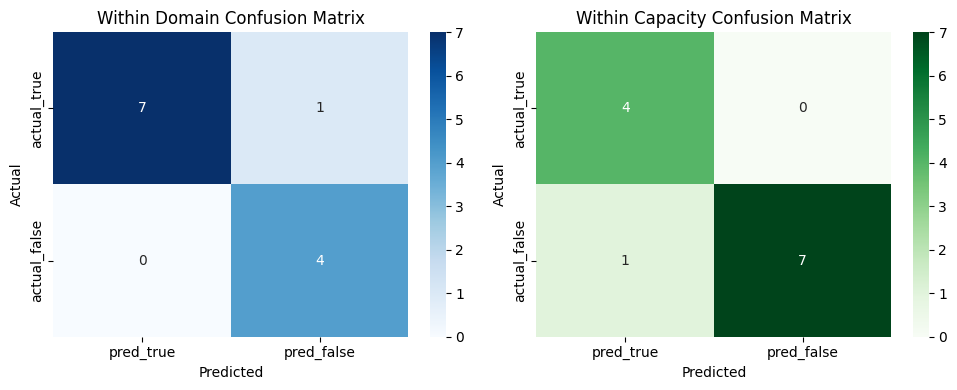

In [8]:

import matplotlib.pyplot as plt  # pyright: ignore[reportMissingImports]
import seaborn as sns  # pyright: ignore[reportMissingImports]
from sklearn.metrics import classification_report, confusion_matrix  # pyright: ignore[reportMissingImports]

# Aggregate evaluation across all datasets and plot confusion matrices
combined_eval = pd.concat(
    [
        eval_df.assign(senario="valid_can_do"),
        eval_valid_cannot_do.assign(senario="valid_cannot_do"),
        eval_invalid.assign(senario="invalid"),
    ],
    ignore_index=True,
)


def compute_binary_metrics(df: pd.DataFrame, target_col: str, pred_col: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    y_true = df[target_col]
    y_pred = df[pred_col]
    report = classification_report(
        y_true,
        y_pred,
        output_dict=True,
        zero_division=0,
    )
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    cm_df = pd.DataFrame(
        cm,
        index=pd.Index(["actual_true", "actual_false"]),
        columns=pd.Index(["pred_true", "pred_false"]),
    )
    return pd.DataFrame(report).T, cm_df


domain_report, domain_cm = compute_binary_metrics(
    combined_eval,
    target_col="target_within_domain",
    pred_col="within_domain",
)
capacity_report, capacity_cm = compute_binary_metrics(
    combined_eval,
    target_col="target_within_capacity",
    pred_col="within_capacity",
)

display(domain_report)
display(capacity_report)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(
    domain_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=axes[0],
)
axes[0].set_title("Within Domain Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(
    capacity_cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    ax=axes[1],
)
axes[1].set_title("Within Capacity Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()